In [49]:
import os
# Use async gpu memory allocation
# os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

In [50]:
# import tensorflow as tf
# import tf_keras as keras
# from tf_keras import layers, losses, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

### Read and analize the dataset

In [51]:
df = pd.read_csv('../datasets/aqi/generated/combined_aqi_bulk_modified.csv')

In [52]:
df.head()

,datetime,o3 (ppm),pm2.5 (µg/m³)
0,2016-11-09 23:00:00+06:00,0.001,61.7
1,2016-11-10 00:00:00+06:00,0.001,67.8
2,2016-11-10 01:00:00+06:00,0.001,109.9
3,2016-11-10 02:00:00+06:00,0.001,127.4
4,2016-11-10 03:00:00+06:00,0.001,122.2


Copy the dataframe

In [53]:
df_copy = df.copy()

Extract the datetime column for visualization

In [54]:
date_time = pd.to_datetime(df_copy.pop('datetime'), format='ISO8601')

Visualize the data distribution

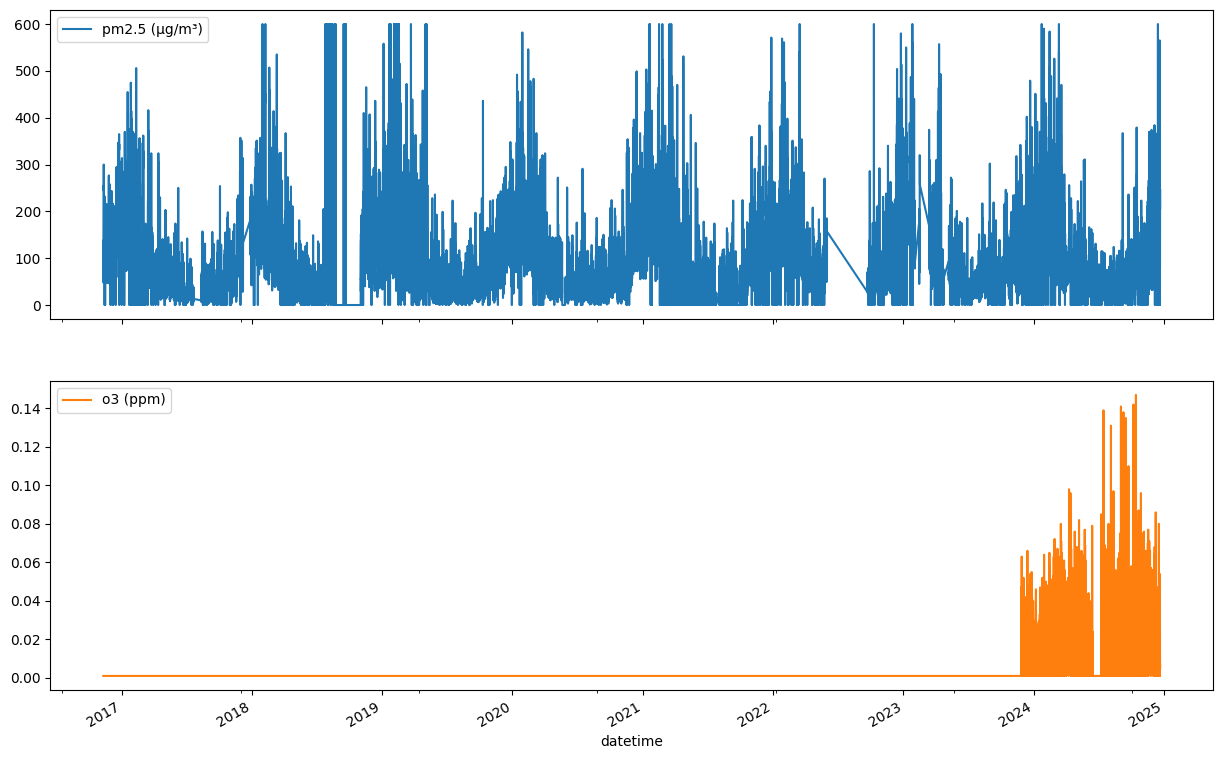

In [55]:
plot_cols = ['pm2.5 (µg/m³)', "o3 (ppm)",]
plot_features = df_copy[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(15, 10))

Visualize the frequency domains of the pm2.5 parameter

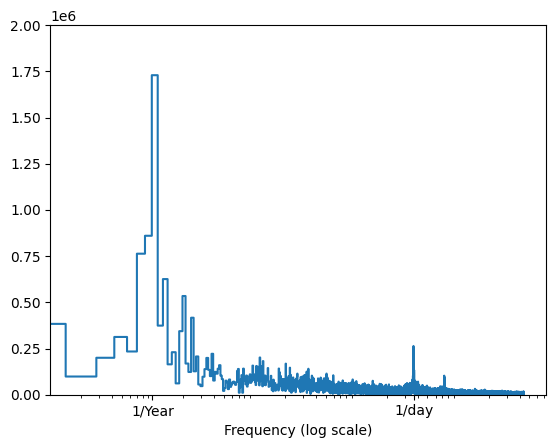

In [56]:
fft = np.fft.rfft(df_copy['pm2.5 (µg/m³)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_copy['pm2.5 (µg/m³)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [57]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

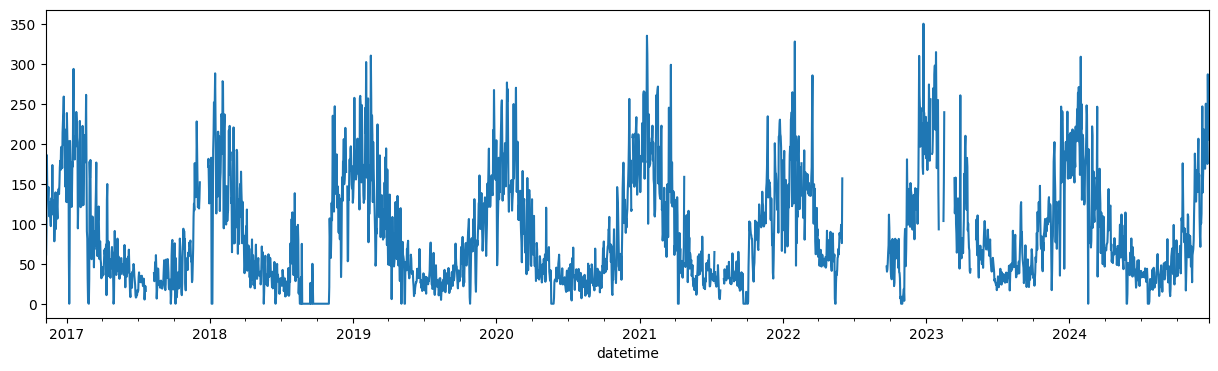

In [118]:
# Copy the dataframe and set index
df2 = df.copy()
df2['datetime'] = pd.to_datetime(df2['datetime'], format='ISO8601')
df2.set_index('datetime', inplace=True)

# Resample data to daily mean or hourly mean
daily_pm25 = df2['pm2.5 (µg/m³)'].resample('D').mean()
hourly_pm25 = df2['pm2.5 (µg/m³)'].resample('h').mean()

# Plot to check trends
plot_features = daily_pm25.copy()
_ = plot_features.plot(figsize=(15, 4), subplots=True)

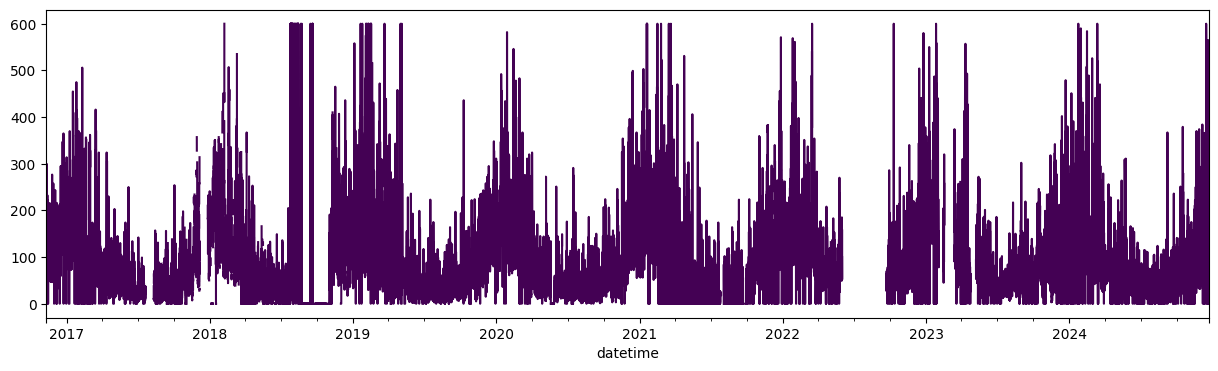

In [59]:

plot_features = hourly_pm25.copy()
_ = plot_features.plot(figsize=(15, 4), subplots=True, colormap='viridis')

Identify and interpolate missing values

Missing values in daily_pm25: 221


<Axes: title={'center': 'PM2.5 Time Series (with Missing Values)'}, xlabel='datetime'>

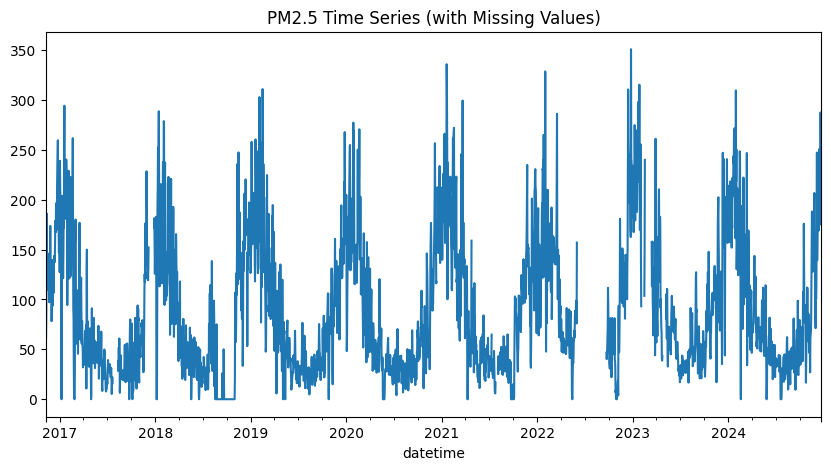

In [74]:
# Check for missing values
missing_count = daily_pm25.isna().sum()
print(f"Missing values in daily_pm25: {missing_count}")

# Visualize missing data
daily_pm25.plot(title="PM2.5 Time Series (with Missing Values)", figsize=(10, 5))

<Axes: title={'center': 'PM2.5 Time Series (linearly interpolated)'}, xlabel='datetime'>

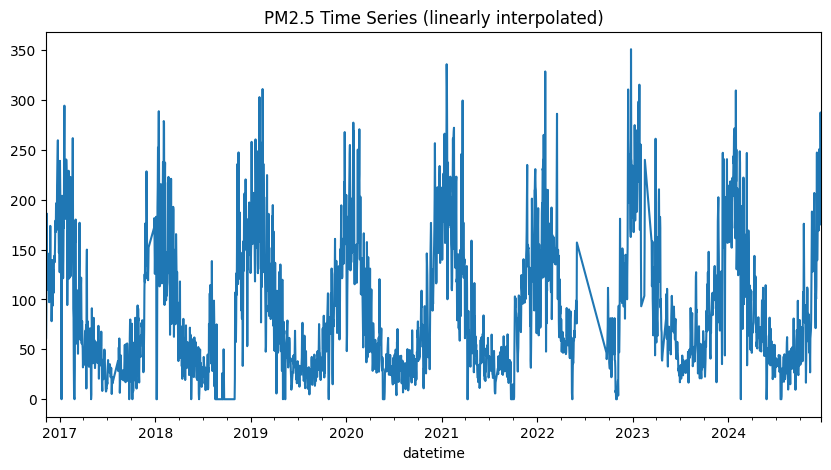

In [63]:
daily_pm25_interpolated = daily_pm25.interpolate(method='linear')

# Visualize missing data
daily_pm25_interpolated.plot(title="PM2.5 Time Series (linearly interpolated)", figsize=(10, 5))

<Axes: title={'center': 'PM2.5 Time Series (timely interpolated)'}, xlabel='datetime'>

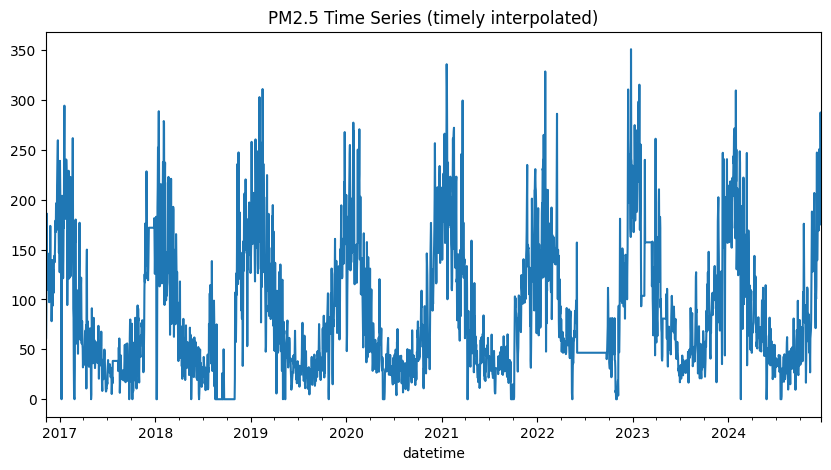

In [92]:
method = ['linear', 'time', 'index', 'values', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'barycentric',
          'krogh', 'spline', 'polynomial', 'from_derivatives', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline',]
daily_pm25_interpolated = daily_pm25.bfill()

# Visualize missing data
daily_pm25_interpolated.plot(
    title="PM2.5 Time Series (timely interpolated)", figsize=(10, 5),)

In [132]:
dpm2 = daily_pm25.copy().to_frame()

In [133]:
dpm2.head()

,pm2.5 (µg/m³)
datetime,
2016-11-09 00:00:00+06:00,61.700000
2016-11-10 00:00:00+06:00,91.887500
2016-11-11 00:00:00+06:00,186.120833
2016-11-12 00:00:00+06:00,141.229167
2016-11-13 00:00:00+06:00,130.891667


In [134]:
dpm2['month_day'] = dpm2.index.strftime('%m-%d')
dpm2.head()

,pm2.5 (µg/m³),month_day
datetime,,
2016-11-09 00:00:00+06:00,61.700000,11-09
2016-11-10 00:00:00+06:00,91.887500,11-10
2016-11-11 00:00:00+06:00,186.120833,11-11
2016-11-12 00:00:00+06:00,141.229167,11-12
2016-11-13 00:00:00+06:00,130.891667,11-13


In [135]:
daily_mean_by_date = dpm2.groupby('month_day').mean()
daily_mean_by_date.head()
# dpm3.index = month_day

,pm2.5 (µg/m³)
month_day,
01-01,170.357598
01-02,173.898090
01-03,153.851042
01-04,173.806066
01-05,147.907813


In [139]:
xxx = daily_mean_by_date['pm2.5 (µg/m³)']
xxx.head()

month_day
01-01    170.357598
01-02    173.898090
01-03    153.851042
01-04    173.806066
01-05    147.907813
Name: pm2.5 (µg/m³), dtype: float64

<Axes: title={'center': 'PM2.5 Daily Mean by Month-Day'}, xlabel='month_day'>

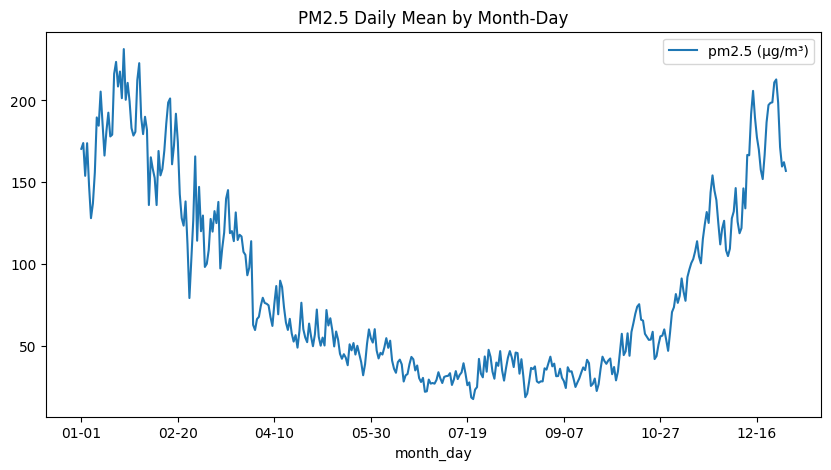

In [136]:
daily_mean_by_date.plot(title="PM2.5 Daily Mean by Month-Day", figsize=(10, 5))

Missing values after interpolation: 0


<Axes: title={'center': 'PM2.5 Time Series (timely interpolated)'}, xlabel='datetime'>

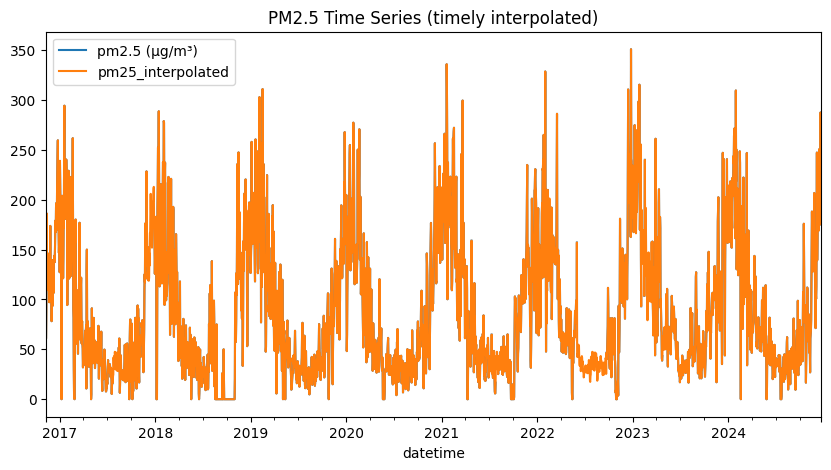

In [140]:
# Step 3: Fill missing values using the daily mean for the same month_day
def interpolate_with_daily_mean(row):
    if pd.isna(row['pm2.5 (µg/m³)']):
        return xxx[row['month_day']]
    return row['pm2.5 (µg/m³)']

dpm2['pm25_interpolated'] = dpm2.apply(interpolate_with_daily_mean, axis=1)
dpm2_interpolated = dpm2['pm25_interpolated']

# Step 5: Confirm interpolation
print(f"Missing values after interpolation: {dpm2_interpolated.isna().sum()}")

# Visualize missing data
dpm2.plot(
    title="PM2.5 Time Series (timely interpolated)", figsize=(10, 5),)

In [141]:
dpm2.head()

,pm2.5 (µg/m³),month_day,pm25_interpolated
datetime,,,
2016-11-09 00:00:00+06:00,61.700000,11-09,61.700000
2016-11-10 00:00:00+06:00,91.887500,11-10,91.887500
2016-11-11 00:00:00+06:00,186.120833,11-11,186.120833
2016-11-12 00:00:00+06:00,141.229167,11-12,141.229167
2016-11-13 00:00:00+06:00,130.891667,11-13,130.891667


In [142]:
daily_pm25 = dpm2.pop('pm25_interpolated')
print(daily_pm25)

datetime
2016-11-09 00:00:00+06:00     61.700000
2016-11-10 00:00:00+06:00     91.887500
2016-11-11 00:00:00+06:00    186.120833
2016-11-12 00:00:00+06:00    141.229167
2016-11-13 00:00:00+06:00    130.891667
                                ...    
2024-12-17 00:00:00+06:00    208.041667
2024-12-18 00:00:00+06:00    175.083333
2024-12-19 00:00:00+06:00    287.333333
2024-12-20 00:00:00+06:00    228.125000
2024-12-21 00:00:00+06:00    206.000000
Freq: D, Name: pm25_interpolated, Length: 2965, dtype: float64


<Axes: title={'center': 'PM2.5 Time Series (timely interpolated)'}, xlabel='datetime'>

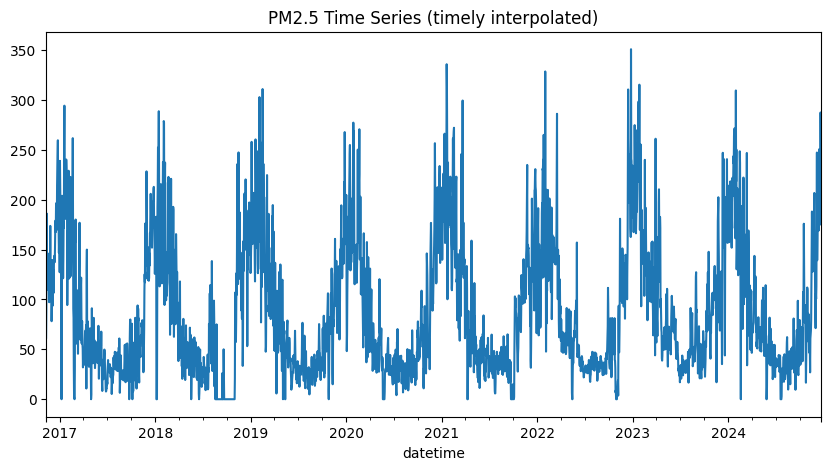

In [143]:
daily_pm25.plot(title="PM2.5 Time Series (timely interpolated)", figsize=(10, 5),)

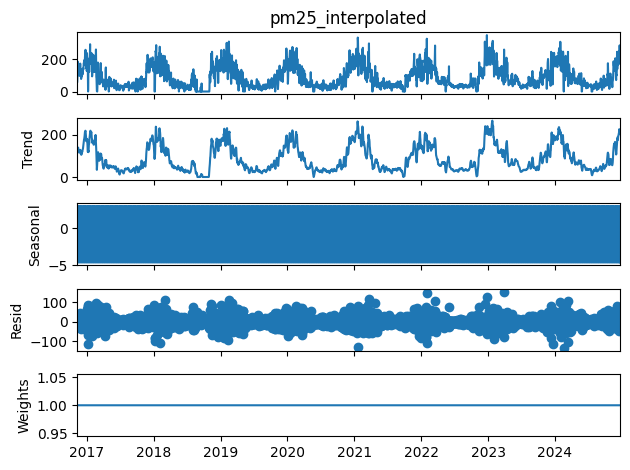

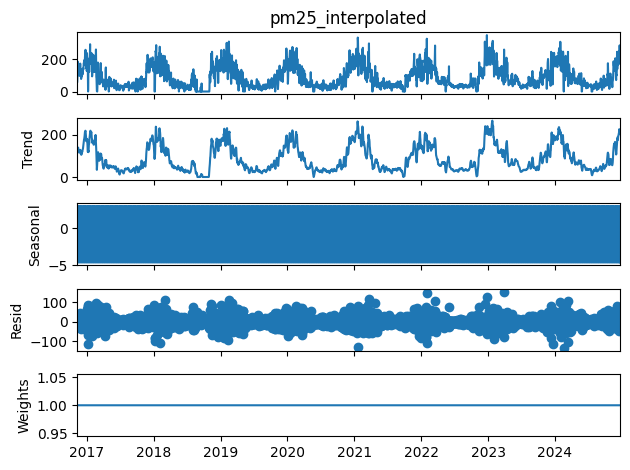

In [147]:
# Extract rolling statistics
df2['rolling_mean_7d'] = daily_pm25.rolling(window=7).mean()
df2['rolling_std_7d'] = daily_pm25.rolling(window=7).std()

# Frequency-domain features
df2['fft_peak_frequency'] = positive_frequencies[np.argmax(positive_power)]
df2['fft_peak_power'] = np.max(positive_power)

# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(daily_pm25, model='additive')
result.plot(weights=True)

In [148]:
# Define AQI thresholds (adjust based on your needs)
safe_threshold = 35.4  # AQI <= 50 is safe
df2['is_safe'] = (df2['pm2.5 (µg/m³)'] <= safe_threshold).astype(int)

# Prepare features and labels
features = df2[['rolling_mean_7d', 'rolling_std_7d', 'fft_peak_frequency', 'fft_peak_power']].dropna()
labels = df2['is_safe'].loc[features.index]

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a classification model
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       374
           1       0.63      0.60      0.61       145

    accuracy                           0.79       519
   macro avg       0.74      0.73      0.74       519
weighted avg       0.79      0.79      0.79       519



In [149]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Prepare data for LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(daily_pm25.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Use 30 days of data to predict the next day
X, y = create_sequences(data_scaled, seq_length)

# Split into train and test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

2024-12-27 16:10:09.809696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735294209.885313    5696 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735294209.906193    5696 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 16:10:10.071143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1735294216.315683    5696 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42

Epoch 1/20


I0000 00:00:1735294220.606660   28306 service.cc:148] XLA service 0x4439eba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735294220.606704   28306 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-27 16:10:20.667845: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735294221.094977   28306 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-27 16:10:21.414649: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 2/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1116 

I0000 00:00:1735294222.119529   28306 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0515
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 13/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082
Epoch 14/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079
Epoch 15/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087
Epoch 16/20
74/74 ━━━━━━━━━━━

In [151]:
import seaborn as sns

# Add predictions to DataFrame
df2['predicted_safe'] = clf.predict(features)
df2['predicted_pm25'] = np.nan
df2.loc[X_test.index, 'predicted_pm25'] = y_pred_rescaled

# Plot safe vs unsafe hours
sns.heatmap(df2.pivot_table(index=df.index.date, columns=df.index.hour, values='is_safe'), cmap='coolwarm')
plt.title("Safe vs Unsafe Hours Heatmap")


ValueError: Length of values (2594) does not match length of index (62184)

In [155]:
daily_pm25.rolling(window=7).mean()

datetime
2016-11-09 00:00:00+06:00           NaN
2016-11-10 00:00:00+06:00           NaN
2016-11-11 00:00:00+06:00           NaN
2016-11-12 00:00:00+06:00           NaN
2016-11-13 00:00:00+06:00           NaN
                                ...    
2024-12-17 00:00:00+06:00    203.160714
2024-12-18 00:00:00+06:00    202.523810
2024-12-19 00:00:00+06:00    219.416667
2024-12-20 00:00:00+06:00    225.934524
2024-12-21 00:00:00+06:00    219.571429
Freq: D, Name: pm25_interpolated, Length: 2965, dtype: float64

/tmp/ipykernel_5696/3024856935.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq("H")


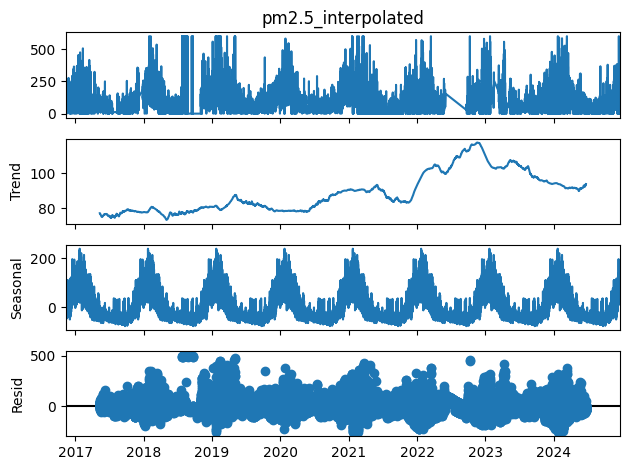

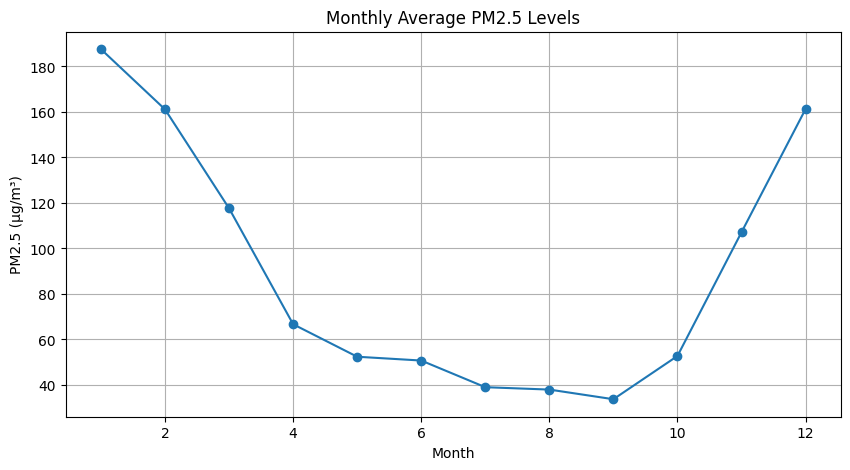

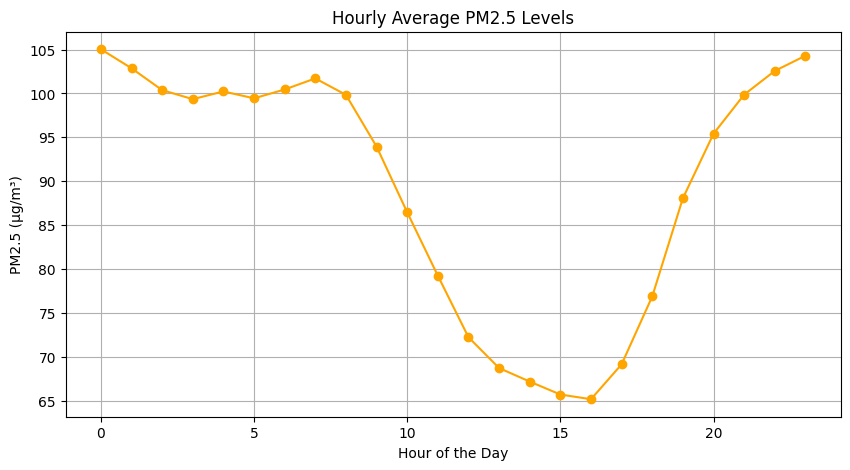

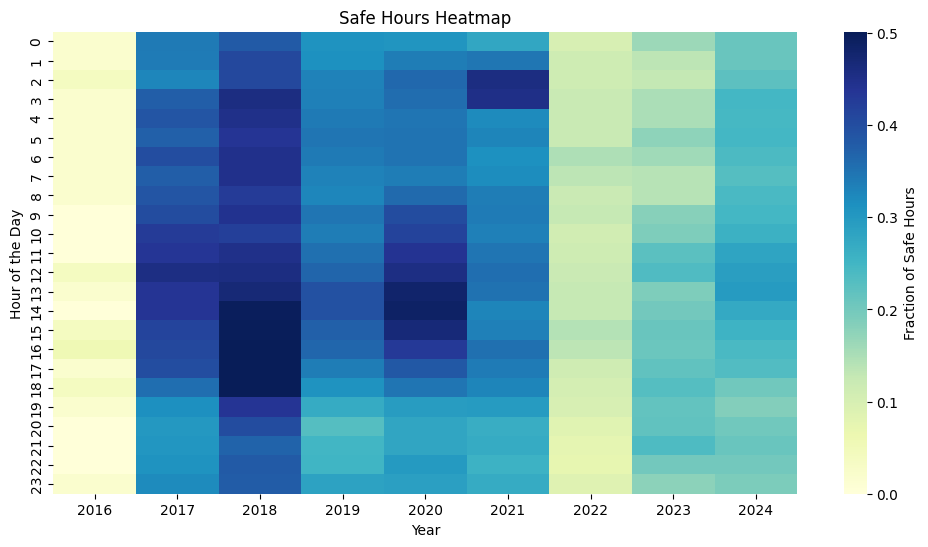

            mean    max  min
year                        
2016  146.360849  364.9  0.0
2017   75.559087  505.9  0.0
2018   76.266838  600.0  0.0
2019   83.864498  600.0  0.0
2020   81.229736  582.0  0.0
2021   89.984932  600.0  0.0
2022  104.284989  600.0  0.0
2023  104.280936  600.0  0.0
2024   91.219516  600.0  0.0


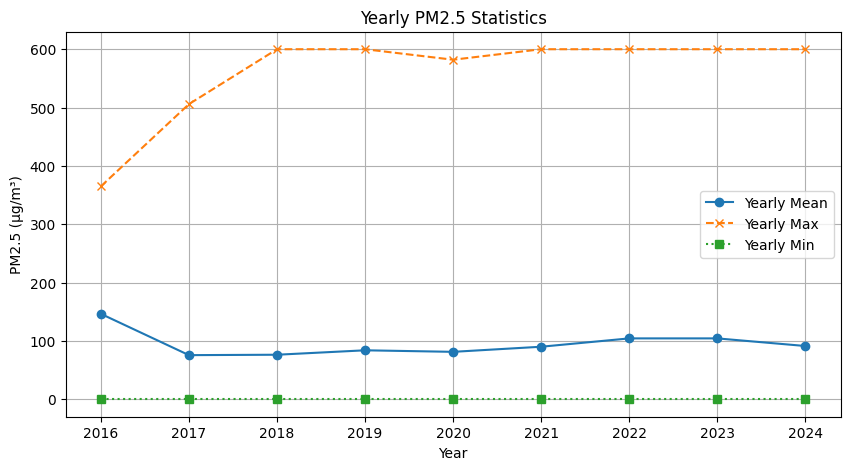

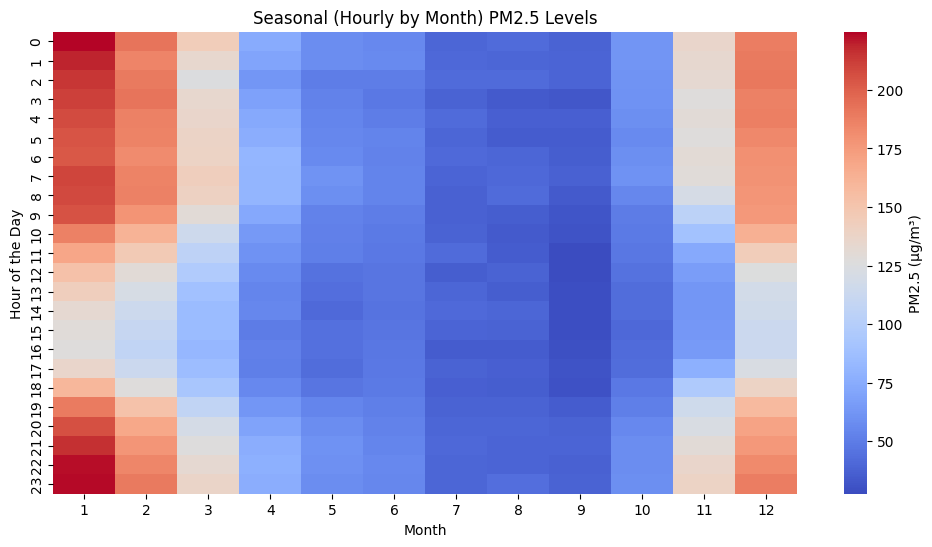

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Load dataset
df = pd.read_csv("../datasets/aqi/generated/combined_aqi_bulk_modified.csv", parse_dates=["datetime"], index_col="datetime")

# Ensure data has a uniform hourly frequency
df = df.asfreq("H")

# Add month, day, and hour columns for analysis
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour
df["year"] = df.index.year

# Interpolate missing values
df["pm2.5_interpolated"] = df["pm2.5 (µg/m³)"].interpolate(method="time")
df["o3_interpolated"] = df["o3 (ppm)"].interpolate(method="time")

# --- Step 1: Time Series Decomposition (Yearly and Seasonal Trends) ---
# Decompose the PM2.5 data into components
result = seasonal_decompose(df["pm2.5_interpolated"], model="additive", period=365 * 24)
result.plot()
plt.show()

# --- Step 2: Seasonal Analysis ---
# Monthly averages
monthly_avg = df.groupby("month")["pm2.5_interpolated"].mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg, marker="o")
plt.title("Monthly Average PM2.5 Levels")
plt.xlabel("Month")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid()
plt.show()

# Hourly averages
hourly_avg = df.groupby("hour")["pm2.5_interpolated"].mean()
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg, marker="o", color="orange")
plt.title("Hourly Average PM2.5 Levels")
plt.xlabel("Hour of the Day")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid()
plt.show()

# --- Step 3: Safe Hour Heatmap ---
# Define safe threshold (e.g., PM2.5 < 35.4 as safe)
safe_hours = df["pm2.5_interpolated"] < 35.4

# Create a pivot table for the heatmap
heatmap_data = safe_hours.groupby([df.index.year, df.index.hour]).mean().unstack(level=0)
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    cbar_kws={"label": "Fraction of Safe Hours"},
    annot=False,
)
plt.title("Safe Hours Heatmap")
plt.xlabel("Year")
plt.ylabel("Hour of the Day")
plt.show()

# --- Step 4: Yearly Analysis ---
# Yearly max, min, and mean
yearly_stats = df.groupby("year")["pm2.5_interpolated"].agg(["mean", "max", "min"])
print(yearly_stats)

plt.figure(figsize=(10, 5))
plt.plot(yearly_stats["mean"], label="Yearly Mean", marker="o")
plt.plot(yearly_stats["max"], label="Yearly Max", linestyle="--", marker="x")
plt.plot(yearly_stats["min"], label="Yearly Min", linestyle=":", marker="s")
plt.title("Yearly PM2.5 Statistics")
plt.xlabel("Year")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid()
plt.show()

# --- Step 5: Seasonal Analysis by Month and Hour ---
# Pivot table for monthly and hourly average PM2.5
seasonal_data = df.pivot_table(
    values="pm2.5_interpolated", index="hour", columns="month", aggfunc="mean"
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    seasonal_data,
    cmap="coolwarm",
    cbar_kws={"label": "PM2.5 (µg/m³)"},
    annot=False,
)
plt.title("Seasonal (Hourly by Month) PM2.5 Levels")
plt.xlabel("Month")
plt.ylabel("Hour of the Day")
plt.show()
